# 1. Khai báo thư viện

In [1]:
import numpy as np
from collections import defaultdict

from process.read_data import read_dataset, clean_process_dataset, one_hot_encoder
from process.evaluation import evaluation, evaluation_value

## CÁC THÔNG SỐ CHÍNH
RANDOM_SEED = 42
TRAIN_RATIO  = 0.8

LIKE_THRESHOLD_GT   = 4.0
LIKE_THRESHOLD_PRED = 0.65

CONTENT_WEIGHT = 0.15


# 2. Đọc dữ liệu

In [2]:
# Đọc dữ liệu gốc
movies, ratings, links = clean_process_dataset(*read_dataset())
movie_encoder, genres_list = one_hot_encoder(movies)
movie_encoder = dict(zip(movie_encoder["movieId"], movie_encoder["genre_vector"]))

# Chia dữ liệu
ratings = ratings.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
split = int(TRAIN_RATIO * len(ratings))

train = ratings.iloc[:split]
test  = ratings.iloc[split:]

train_by_user = defaultdict(list)
for _, r in train.iterrows():
    train_by_user[r.userId].append((r.movieId, r.rating))

# 3. Content-based

## 3.1 User profile (weighted)

In [3]:
def build_user_profile(movie_encoder, user):
    items = train_by_user.get(user)
    if not items:
        return None

    # khởi tạo vector người dùng
    profile = np.zeros(len(next(iter(movie_encoder.values()))), dtype=float)
    w_sum = 0.0

    for m, r in items:
        if m in movie_encoder:
            profile += r * np.asarray(movie_encoder[m], dtype=float)
            w_sum += r

    return profile / w_sum if w_sum > 0 else None

## 3.2 Độ tương đồng

In [4]:
def cosine(a, b):
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    return 0.0 if denom == 0 else float(np.dot(a, b) / denom)

## Dự đoán

In [5]:
def content_score(user, movie):
    profile = build_user_profile(movie_encoder, user)
    return None if profile is None else cosine(profile, movie_encoder[movie])

# 4. Model-based Collaborative

## 4.1 Deviation matrix

In [6]:
dev = defaultdict(lambda: defaultdict(float))
cnt = defaultdict(lambda: defaultdict(int))

for items in train_by_user.values():
    for i, ri in items:
        for j, rj in items:
            if i != j:
                dev[i][j] += ri - rj
                cnt[i][j] += 1

for i in dev:
    for j in dev[i]:
        dev[i][j] /= cnt[i][j]

## 4.2 Dự đoán

In [7]:
def slope_one_score(user, movie):
    items = train_by_user[user]
    num = den = 0.0

    for j, rj in items:
        if j in dev[movie]:
            w = cnt[movie][j]
            num += (dev[movie][j] + rj) * w
            den += w

    return None if den == 0 else num / den

# 5. Hybrid 

In [8]:
def hybrid_score(user, movie):
    c = content_score(user, movie)
    s = slope_one_score(user, movie)

    if c is None and s is None:
        return None
    if s is None:
        return c
    if c is None:
        return s / 5.0

    return CONTENT_WEIGHT * c + (1 - CONTENT_WEIGHT) * (s / 5.0)

# 6. Đánh giá

In [9]:
TP = FP = FN = TN = 0
for _, row in test.iterrows():
    u, m, r = row.userId, row.movieId, row.rating

    score = hybrid_score(u, m)
    if score is None:
        continue

    y_true = r >= LIKE_THRESHOLD_GT
    y_pred = score >= LIKE_THRESHOLD_PRED

    if y_true and y_pred: TP += 1
    elif not y_true and y_pred: FP += 1
    elif y_true and not y_pred: FN += 1
    else: TN += 1

# Chạy đánh giá

HYBRID CONTENT-BASED + COLLABORATIVE (CLASSIFICATION)
Precision : 0.65
Recall    : 0.80
F1-Score  : 0.72


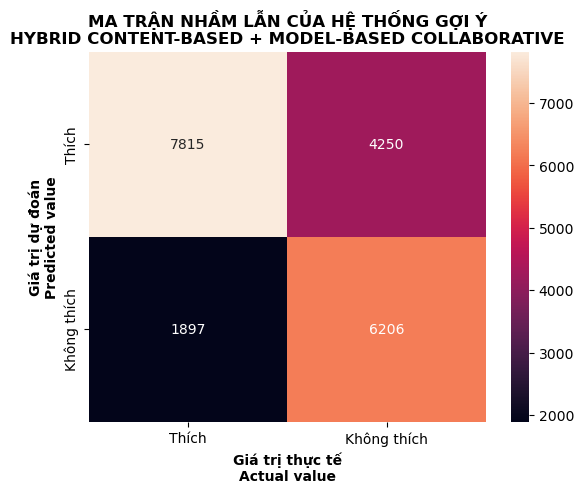

TP: 7815 | FP: 4250
FN: 1897 | TN: 6206


In [10]:
print("=" * 60)
print("HYBRID CONTENT-BASED + COLLABORATIVE (CLASSIFICATION)")
print("=" * 60)
evaluation(TP, FP, FN, TN)
print("=" * 60)

In [15]:
import numpy as np

threshold_list = np.arange(0, 1.01, 0.05)  # LIKE_THRESHOLD_PRED từ 0.05 → 1.0
content_weight_list = np.arange(0, 1.01, 0.05)       # ALPHA từ 0.4 → 0.8

F1_matrix = np.zeros((len(content_weight_list), len(threshold_list)))
Precision_matrix = np.zeros_like(F1_matrix)
Recall_matrix    = np.zeros_like(F1_matrix)

for i, content_weight in enumerate(content_weight_list):
    CONTENT_WEIGHT = content_weight
    for j, threshold in enumerate(threshold_list):
        TP = FP = FN = TN = 0
        for _, row in test.iterrows():
            u, m, r = row.userId, row.movieId, row.rating
            score = hybrid_score(u, m)
            if score is None:
                continue

            y_true = r >= LIKE_THRESHOLD_GT
            y_pred = score >= threshold

            if y_true and y_pred: TP += 1
            elif not y_true and y_pred: FP += 1
            elif y_true and not y_pred: FN += 1
            else: TN += 1

        precision, recall, f1_score = evaluation_value(TP, FP, FN, TN)


        Precision_matrix[i, j] = precision
        Recall_matrix[i, j]    = recall
        F1_matrix[i, j]        = f1_score
        print(f'[Content weight: {CONTENT_WEIGHT:.2f} - Threshold: {threshold:.2f}] Precision: {precision} | Recall: {recall} | F1-Score: {f1_score}')


[Content weight: 0.00 - Threshold: 0.00] Precision: 0.48174603174603176 | Recall: 1.0 | F1-Score: 0.6502410283877879
[Content weight: 0.00 - Threshold: 0.05] Precision: 0.48165821652251717 | Recall: 0.9977347611202636 | F1-Score: 0.6496815286624205
[Content weight: 0.00 - Threshold: 0.10] Precision: 0.4819943218608358 | Recall: 0.9963962108731467 | F1-Score: 0.6497029104703079
[Content weight: 0.00 - Threshold: 0.15] Precision: 0.4821785143769968 | Recall: 0.9945428336079077 | F1-Score: 0.6494755244755245
[Content weight: 0.00 - Threshold: 0.20] Precision: 0.48276207155366524 | Recall: 0.9934102141680395 | F1-Score: 0.6497626022830589
[Content weight: 0.00 - Threshold: 0.25] Precision: 0.4841253893298503 | Recall: 0.9922775947281713 | F1-Score: 0.6507529205213046
[Content weight: 0.00 - Threshold: 0.30] Precision: 0.48624873609706776 | Recall: 0.9903212520593081 | F1-Score: 0.6522446765224468
[Content weight: 0.00 - Threshold: 0.35] Precision: 0.48982610026008466 | Recall: 0.9889827018

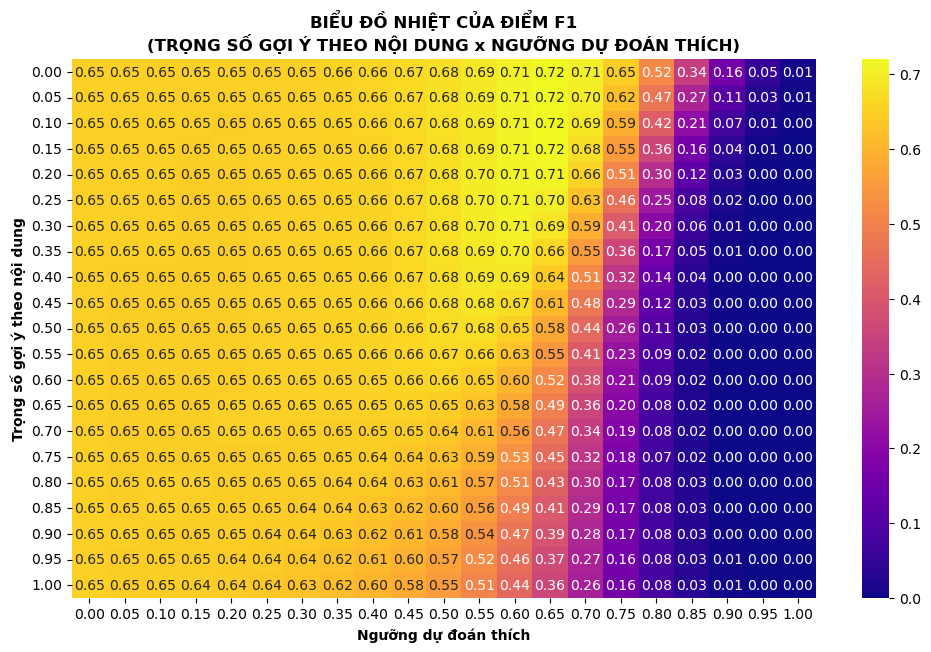

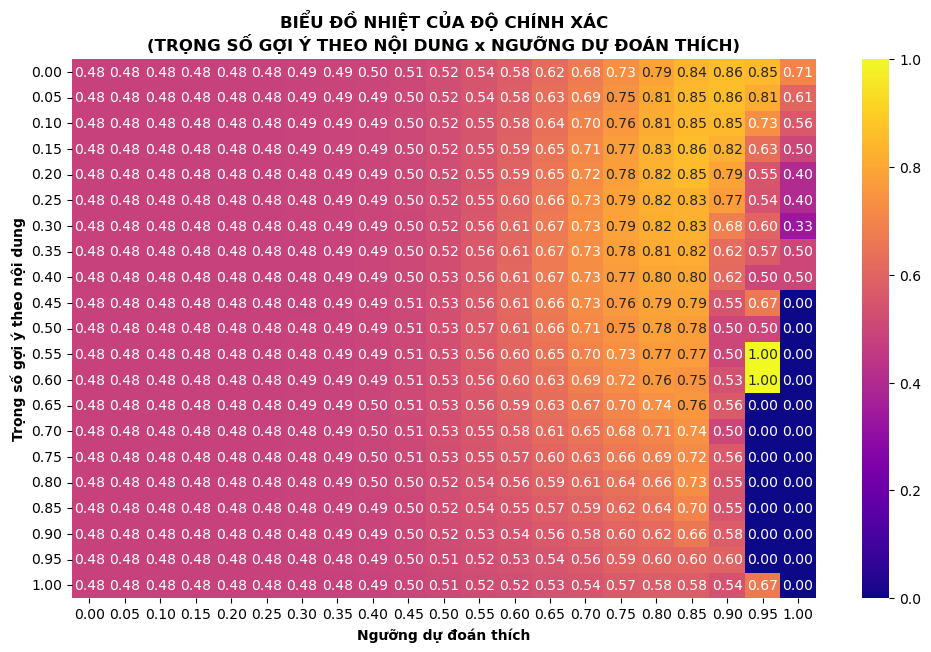

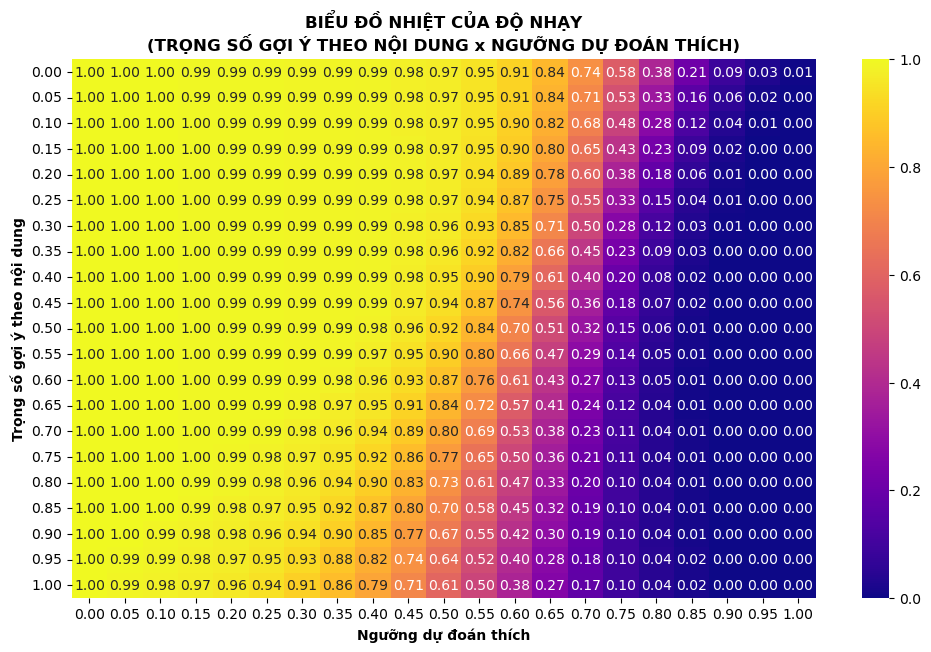

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Giả sử các ma trận đã tính xong: F1_matrix, Precision_matrix, Recall_matrix
# alphαs và thresholds cũng đã có

# Chuyển thành DataFrame để dễ hiển thị
df_f1 = pd.DataFrame(F1_matrix, index=np.round(content_weight_list,2), columns=np.round(threshold_list,2))
df_precision = pd.DataFrame(Precision_matrix, index=np.round(content_weight_list,2), columns=np.round(threshold_list,2))
df_recall = pd.DataFrame(Recall_matrix, index=np.round(content_weight_list,2), columns=np.round(threshold_list,2))

# Vẽ Heatmap cho F1
plt.figure(figsize=(12,7))
sns.heatmap(df_f1, annot=True, fmt=".2f", cmap="plasma",
            xticklabels=[f"{x:.2f}" for x in df_f1.columns],
            yticklabels=[f"{y:.2f}" for y in df_f1.index])
plt.title("BIỂU ĐỒ NHIỆT CỦA ĐIỂM F1\n(TRỌNG SỐ GỢI Ý THEO NỘI DUNG x NGƯỠNG DỰ ĐOÁN THÍCH)", fontweight='bold')
plt.xlabel("Ngưỡng dự đoán thích", fontweight='bold')
plt.ylabel("Trọng số gợi ý theo nội dung", fontweight='bold')
plt.show()

# Vẽ Heatmap cho Precision
plt.figure(figsize=(12,7))
sns.heatmap(df_precision, annot=True, fmt=".2f", cmap="plasma", 
            xticklabels=[f"{x:.2f}" for x in df_f1.columns],
            yticklabels=[f"{y:.2f}" for y in df_f1.index])
plt.title("BIỂU ĐỒ NHIỆT CỦA ĐỘ CHÍNH XÁC\n(TRỌNG SỐ GỢI Ý THEO NỘI DUNG x NGƯỠNG DỰ ĐOÁN THÍCH)", fontweight='bold')
plt.xlabel("Ngưỡng dự đoán thích", fontweight='bold')
plt.ylabel("Trọng số gợi ý theo nội dung", fontweight='bold')
plt.show()

# Vẽ Heatmap cho Recall
plt.figure(figsize=(12,7))
sns.heatmap(df_recall, annot=True, fmt=".2f", cmap="plasma",
            xticklabels=[f"{x:.2f}" for x in df_f1.columns],
            yticklabels=[f"{y:.2f}" for y in df_f1.index])
plt.title("BIỂU ĐỒ NHIỆT CỦA ĐỘ NHẠY\n(TRỌNG SỐ GỢI Ý THEO NỘI DUNG x NGƯỠNG DỰ ĐOÁN THÍCH)", fontweight='bold')
plt.xlabel("Ngưỡng dự đoán thích", fontweight='bold')
plt.ylabel("Trọng số gợi ý theo nội dung", fontweight='bold')
plt.show()
